In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from VAE import VAE

import scanpy as sc

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as T
from torch.optim import lr_scheduler

### MNIST example

In [33]:
# binary MNIST
dataset = MNIST('../data/', train=True, download=True,
            transform=T.Compose([T.ToTensor(), \
                                 T.Lambda(lambda x: torch.flatten(x))]), 
            target_transform=T.Compose([T.Lambda(lambda x: torch.LongTensor([x])), 
                                        T.Lambda(lambda x: F.one_hot(x,10)), 
                                        T.Lambda(lambda x: torch.squeeze(x))]))

trainloader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

# initialize conditional VAE
# n_conditions is number of conditions for each sample
# eg binary label, or one-hot vector for multi-class
cvae = VAE(n_features=784, z_dim=32, layer_sizes=[256,128], generative_model='mse', kl_weight=1e-7, n_conditions=10)
optimizer = torch.optim.Adam(cvae.parameters(), lr=5e-3)

Epoch 1 mean loss: 0.0311
Epoch 2 mean loss: 0.0191
Epoch 3 mean loss: 0.0165
Epoch 4 mean loss: 0.0149
Epoch 5 mean loss: 0.0140
Epoch 6 mean loss: 0.0131
Epoch 7 mean loss: 0.0126
Epoch 8 mean loss: 0.0122
Epoch 9 mean loss: 0.0116
Epoch 10 mean loss: 0.0114
Epoch 11 mean loss: 0.0111
Epoch 12 mean loss: 0.0109
Epoch 13 mean loss: 0.0108
Epoch 14 mean loss: 0.0105
Epoch 15 mean loss: 0.0103
Epoch 16 mean loss: 0.0103
Epoch 17 mean loss: 0.0102
Epoch 18 mean loss: 0.0101
Epoch 19 mean loss: 0.0100
Epoch 20 mean loss: 0.0099


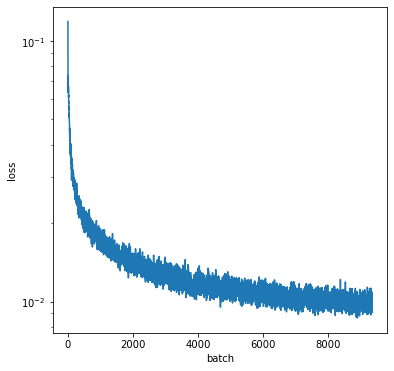

In [34]:
n_epoch = 20
loss_list = []
for epoch in range(n_epoch):
    epoch_loss_list = []
    for x, label in trainloader:
        optimizer.zero_grad()

        # forward pass through network
        # training samples are paired with condition label
        _, _, loss = cvae.forward(x, condition_labels=label)

        # backpropagate gradients
        loss.backward()
        epoch_loss_list.append(loss.detach())

        # update model weights
        optimizer.step()

    print(f'Epoch {epoch+1} mean loss: {np.mean(epoch_loss_list):.4f}')
    loss_list.extend(epoch_loss_list)

plt.figure(figsize=(6,6))
plt.plot(loss_list)
plt.yscale('log')
plt.xlabel('batch')
plt.ylabel('loss');

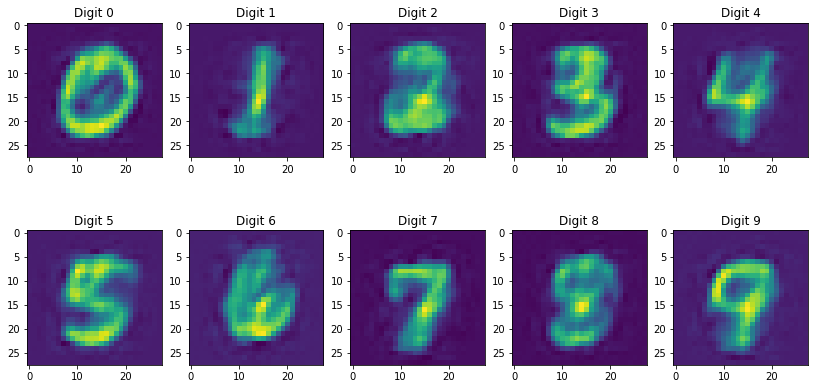

In [35]:
# visualize the mean reconstruction for each condition label
# condition label corresponds to handwritten digit (1-10)
f, ax = plt.subplots(nrows=2, ncols=5, figsize=(14,7))
for i in range(10):
    l = np.zeros((1,10))
    l[0,i] = 1
    out = cvae.decoder(torch.zeros(1,32), condition_labels=torch.from_numpy(l).float())
    ax[int(np.floor(i/5)),i%5].set_title(f'Digit {i}')
    ax[int(np.floor(i/5)),i%5].imshow(out[0].detach().reshape(28,28))

In [48]:
X = dataset.data.reshape(-1,784).float()

labels = dataset.targets

labels_one_hot = F.one_hot(labels,10)

In [49]:
_ = cvae.forward(X, labels_one_hot)

<AxesSubplot: >

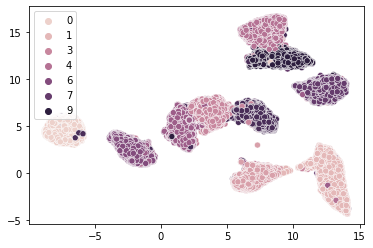

In [50]:
import umap
import seaborn as sns

reducer = umap.UMAP()

z_umap = reducer.fit_transform(cvae.z.detach())

sns.scatterplot(x=z_umap[:,0], y=z_umap[:,1], hue=labels)